
# EVs - modeling 

goal: model the impact of EVs on the grid

In [96]:
## Necessaries libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import json
import requests
from datetime import datetime
from datetime import timedelta
import random
import warnings

In [97]:
warnings.filterwarnings("ignore")

## Metadata on EVs and their usage

In [98]:
## data on EV adoption from: https://www.bfs.admin.ch/bfs/en/home/statistics/mobility-transport/transport-infrastructure-vehicles/vehicles/road-vehicles-stock-level-motorisation.html

## Decide the consrtaint for the number of different vehicles present in 2050

Ideas:
- could show the variation of EVs over Switzerland (for different cantons) and over time
- be able to play with the constraints => different scenarios 

## Estimate the evolution of numbers EVs in Switzerland and the technology

In [99]:
data = pd.read_csv('/Users/yanistournier/Desktop/EnergyNow2.0/data/ev_data.csv', encoding='ISO-8859-1')
data["Canton"].unique()


array(['Switzerland', 'Zürich', 'Bern', 'Luzern', 'Uri', 'Schwyz',
       'Obwalden', 'Nidwalden', 'Glarus', 'Zug', 'Fribourg', 'Solothurn',
       'Basel-Stadt', 'Basel-Landschaft', 'Schaffhausen',
       'Appenzell-Ausserrhoden', 'Appenzell-Innerrhoden', 'Sankt Gallen',
       'Graubünden', 'Aargau', 'Thurgau', 'Ticino', 'Vaud', 'Valais',
       'Neuchâtel', 'Genève', 'Jura', 'Confederation'], dtype=object)

In [100]:
data.head()

,Canton,Vehicle group / type,Fuel,1990,1991,1992,1993,1994,1995,1996,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Switzerland,> Passenger cars,Petrol,2905762,2975154,3006666,3022762,3073062,3132238,3166299,...,3234560,3201710,3173806,3149902,3127023,3114726,3099442,3087390,3054773,2991092
1,Switzerland,> Passenger cars,Diesel,79129,81883,83640,85703,90747,95585,100412,...,1035843,1123676,1214075,1291500,1346938,1374246,1382645,1379077,1360111,1319337
2,Switzerland,> Passenger cars,Electricity,409,671,771,774,775,770,759,...,2683,4439,7531,10724,14539,19181,28716,43396,71697,110751
3,Switzerland,> Passenger cars,Other,97,90,151,284,458,583,623,...,47799,54665,62657,71903,82323,94535,113149,148472,222785,300100
4,Switzerland,> Passenger cars,Without motor,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
def process_data(df:  pd.core.frame.DataFrame)  -> pd.DataFrame:
    ## Function to keep useful information from the data 
    df = df[(df["Canton"] == "Switzerland") & (df["Vehicle group / type"] == "> Passenger cars")].drop(columns=['Canton', 'Vehicle group / type'])
    df.set_index('Fuel', inplace=True)
    df = df.T
    df.drop(columns=["Without motor"], inplace=True)
    df.rename(columns={'Other': 'hybrid', 'Electricity': 'battery_electric'}, inplace=True)
    df["total_car"] = df.sum(axis=1)
    df['Year'] = df.index
    df = df.reset_index(drop=True)
    return df


In [102]:
def plot_evolution(df: pd.core.frame.DataFrame) -> None:
    plt.figure(figsize=(15, 8))
    
    sns.lineplot(data=df, x='Year', y='Petrol', label='Petrol')
    sns.lineplot(data=df, x='Year', y='Diesel', label='Diesel')
    sns.lineplot(data=df, x='Year', y='hybrid', label='Hybrid')
    sns.lineplot(data=df, x='Year', y='battery_electric', label='Battery electric')
    sns.lineplot(data=df, x='Year', y='total_car', label='Total')
    
    # Set the x-ticks and labels for every 2 years
    x_ticks = df['Year'].unique()[::2]
    x_tick_labels = [str(year) for year in x_ticks]
    
    plt.xticks(ticks=x_ticks, labels=x_tick_labels)
    

    plt.legend()
    plt.xlabel('Year')
    plt.ylabel('Number of cars')
    plt.title('Evolution of the number of cars in Switzerland over years')
    plt.show()

In [103]:
class forecast_number_car():
    def __init__(self, df : pd.DataFrame, year_constraint, petrol_constraint, diesel_constraint, hybrid_constraint, battery_elecrtic_constraint, pol_degree, weights = "exp") -> None:
        self.df = df
        self.year_constraint = year_constraint
        self.end_year = self.df["Year"].astype(int).max()
        self.petrol_constraint = petrol_constraint
        self.diesel_constraint = diesel_constraint
        self.hybrid_constraint = hybrid_constraint
        self.battery_elecrtic_constraint = battery_elecrtic_constraint
        self.pol_degree = pol_degree
        self.weights = weights
        self.__df_constraint()
        self.__polynomial_regression()
        self.__concat_df()

    def __df_constraint(self) -> pd.DataFrame:
        total_car_constraint = self.petrol_constraint + self.diesel_constraint + self.hybrid_constraint + self.battery_elecrtic_constraint
        intercept_value = pd.DataFrame({"Year": self.year_constraint, "Petrol": self.petrol_constraint, "Diesel": self.diesel_constraint, "hybrid": self.hybrid_constraint, "battery_electric": self.battery_elecrtic_constraint, "total_car": total_car_constraint}, index=[0])
        self.df = pd.concat([self.df, intercept_value], ignore_index=True)

    def __polynomial_regression(self) -> pd.DataFrame:

        if self.weights == "exp":
            weights = np.exp(np.linspace(-10, 0, len(self.df)))
        else:
            weights = np.linspace(0, 1, len(self.df))

        self.data_ev_forecast = pd.DataFrame({'Year': list(range(self.end_year, self.year_constraint))})

        # Create a loop to perform polynomial regression for each column
        for col in self.df.columns:
            if col == 'Year':
                continue  # Skip the 'Year' column
    
            # Create polynomial features
            poly = PolynomialFeatures(degree=self.pol_degree)
            X_poly = poly.fit_transform(self.df[['Year']])
    
            # Create a linear regression model
            model = LinearRegression()
    
            # Fit the model to the polynomial features for the current column
            model.fit(X_poly, self.df[col], sample_weight=weights)
    
            # Forecast future values for each year from 2024 to 2050
            years_forecast = list(range(self.end_year, self.year_constraint))
            future_years_poly = poly.transform(np.array(years_forecast).reshape(-1, 1))
            predictions = model.predict(future_years_poly)
    
            # Create a new column with the predicted values and add it to the DataFrame
            self.data_ev_forecast[col] = predictions

    def __concat_df(self) -> pd.DataFrame:
        self.df = pd.concat([self.df, self.data_ev_forecast], ignore_index=True)
        self.df = self.df.astype({'Year': str})
        self.df = self.df.sort_values(by=['Year'])

    def get_df(self) -> pd.DataFrame:
        return self.df
    

In [104]:
data_ev = process_data(data)
data_ev.head()

Fuel,Petrol,Diesel,battery_electric,hybrid,total_car,Year
0,2905762,79129,409,97,2985397,1990
1,2975154,81883,671,90,3057798,1991
2,3006666,83640,771,151,3091228,1992
3,3022762,85703,774,284,3109523,1993
4,3073062,90747,775,458,3165042,1994


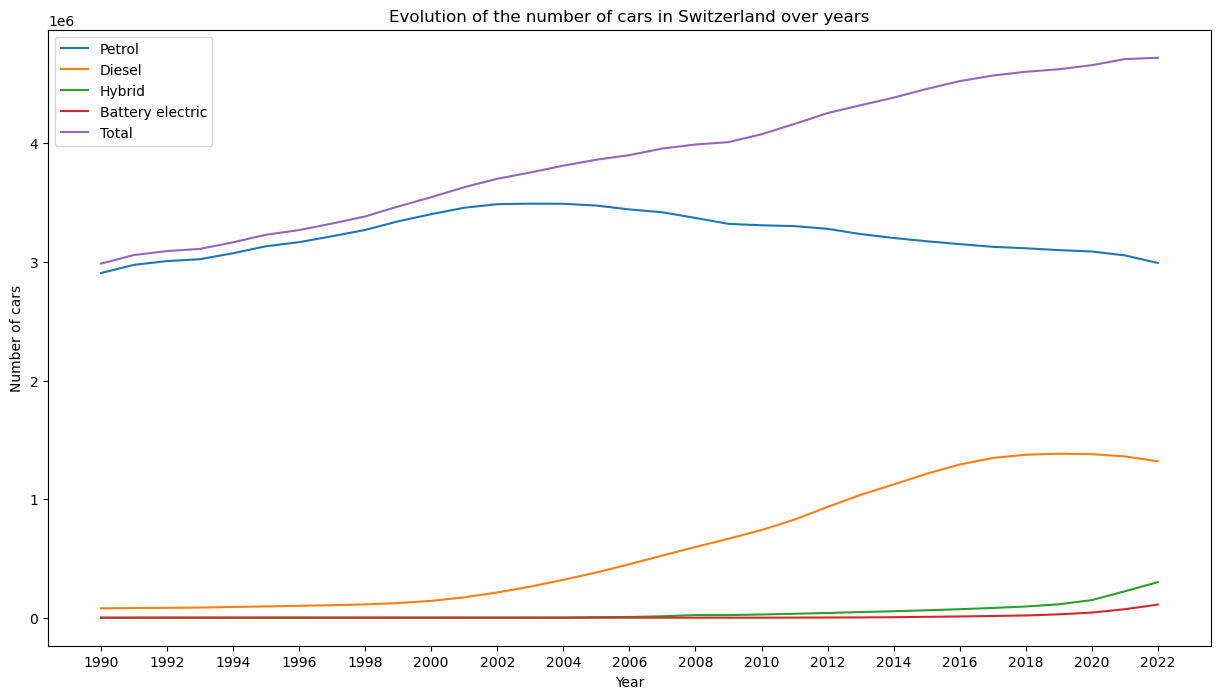

In [105]:
# Plot the evolution of the number of cars in Switzerland over years from historical data

plot_evolution(data_ev)

In [106]:
# Forecasting the number of cars in Switzerland with a plynomial regression model up to 2050

data_ev_forecast = forecast_number_car(data_ev, year_constraint=2050, petrol_constraint=10000, diesel_constraint=0 , hybrid_constraint = 1e6, battery_elecrtic_constraint=5e6, pol_degree=3, weights = "exp").get_df()
data_ev_forecast.tail()

,Petrol,Diesel,battery_electric,hybrid,total_car,Year
58,754353.650391,330682.414185,3.638102e+06,1.020665e+06,5.743852e+06,2046
59,580752.102417,250535.464600,3.952155e+06,1.022319e+06,5.805813e+06,2047
60,398975.319702,168524.371521,4.283508e+06,1.019628e+06,5.870690e+06,2048
61,208818.421387,84774.525513,4.632617e+06,1.012366e+06,5.938633e+06,2049
33,10000.000000,0.000000,5.000000e+06,1.000000e+06,6.010000e+06,2050


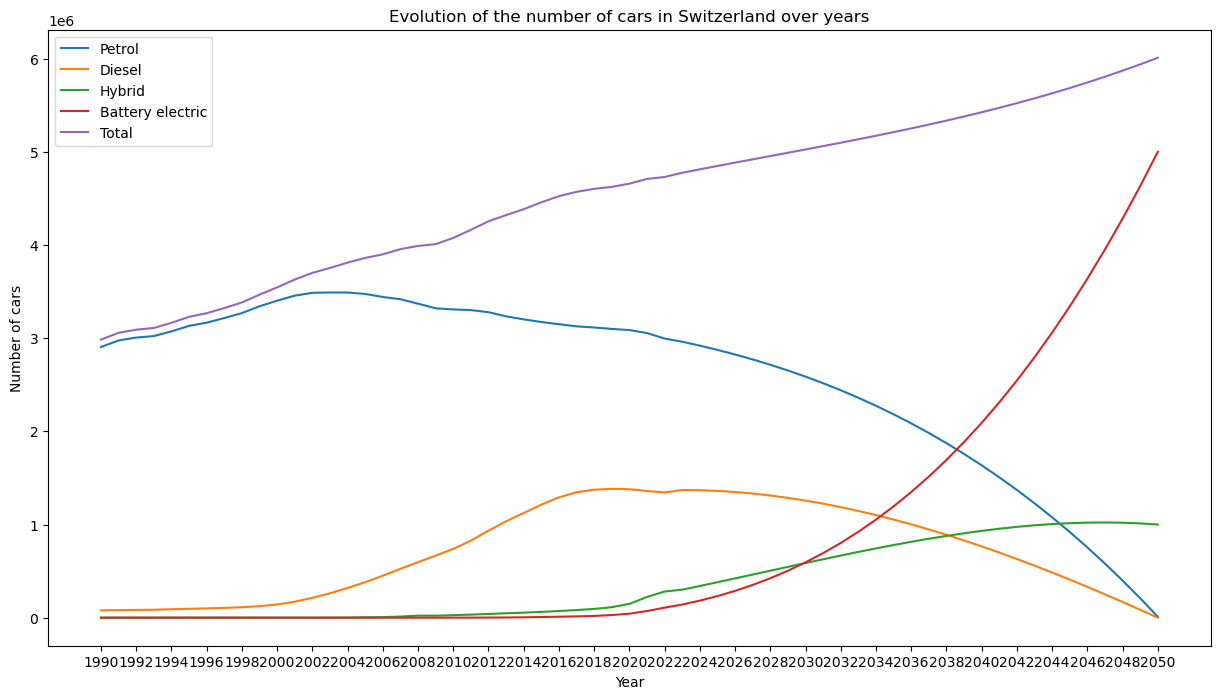

In [107]:
plot_evolution(data_ev_forecast)

In [108]:
# Get the number of cars in Switzerlanf in a certain year

def get_number_EV(df: pd.DataFrame, year: int) -> int:
    return int(df[df["Year"] == str(year)]["battery_electric"].values[0])

get_number_EV(data_ev_forecast, 2040)

2091560

## Model the distibution of charging start time over a day 

In [109]:
# Loading and creating a dataframe with the different charging events from Caltech

with open('/Users/yanistournier/Desktop/EnergyNow2.0/data/acndata_sessions.json', 'r') as file:        data = json.load(file)

items = data["_items"]

# Create a list of dictionaries with the desired columns
data_list = []
for item in items:
    data_list.append({
        "connection_time": item["connectionTime"],
        "done_charging_time": item["doneChargingTime"],
        "kwh_delivered": item["kWhDelivered"]
    })

print("number of charging events: {}".format(len(data["_items"])))
# Create a DataFrame
data_charging = pd.DataFrame(data_list)
# Create a new column with just the time of the day

data_charging["hour"] = pd.to_datetime(data_charging["connection_time"]).dt.strftime('%H:%M')

# data_charging['15_min_interval'] = pd.to_datetime(data_charging['connection_time']).apply(lambda x: x - timedelta(minutes=x.minute % 15, seconds=x.second, microseconds=x.microsecond)).dt.strftime('%H:%M')

data_charging['15_min_interval'] = pd.to_datetime(data_charging['connection_time']).apply(lambda x: (x + timedelta(hours=2) - timedelta(minutes=x.minute % 15, seconds=x.second, microseconds=x.microsecond)).strftime('%H:%M'))

event_counts = data_charging.groupby('15_min_interval').size().reset_index(name='event_count')
event_counts["probability"] = event_counts["event_count"] / event_counts["event_count"].sum()
event_counts


number of charging events: 17798


,15_min_interval,event_count,probability
0,00:00,182,0.010226
1,00:15,156,0.008765
2,00:30,154,0.008653
3,00:45,153,0.008596
4,01:00,186,0.010451
...,...,...,...
91,22:45,234,0.013148
92,23:00,208,0.011687
93,23:15,181,0.010170
94,23:30,169,0.009495


In [110]:
def visualize_kwh_delivered(df):
    df = df.sort_values(by=['kwh_delivered'], ascending=False).reset_index(drop=True).copy()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df,x = df.index, y='kwh_delivered')
    plt.xticks(rotation=90)
    plt.xlabel('Number of sessions')
    plt.ylabel('kwh delivered')
    plt.title('Distribution of kwh delivered over sessions')
    plt.show()

In [111]:
random_kwh = data_charging.sample(n=1)["kwh_delivered"]
random_kwh

4862    8.648
Name: kwh_delivered, dtype: float64

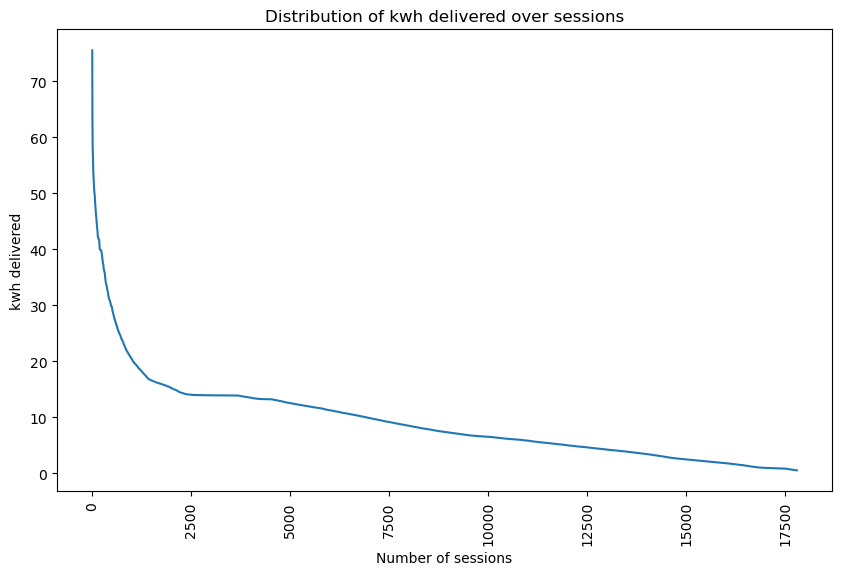

In [112]:
# plot the number of kwh_delivered

visualize_kwh_delivered(data_charging)

In [113]:

event_counts.head()

,15_min_interval,event_count,probability
0,00:00,182,0.010226
1,00:15,156,0.008765
2,00:30,154,0.008653
3,00:45,153,0.008596
4,01:00,186,0.010451


In [114]:
sampled_time = np.random.choice(event_counts['15_min_interval'], p=event_counts['probability'])
sampled_time

'03:45'

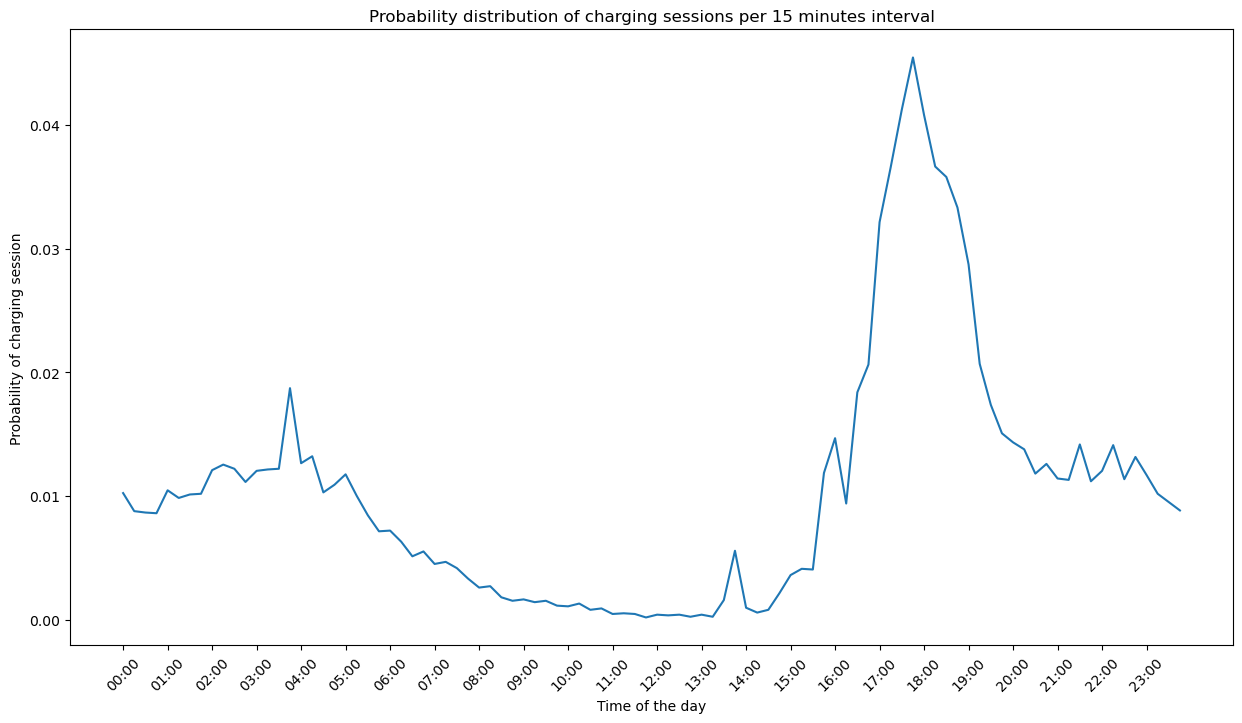

In [115]:
plt.figure(figsize=(15, 8))
ax = plt.gca()  # Get the current axes

sns.lineplot(data=event_counts, x='15_min_interval', y='probability', ax=ax)
ax.set_xlabel('Time of the day')
ax.set_ylabel('Probability of charging session')
ax.set_title('Probability distribution of charging sessions per 15 minutes interval')

# Set the x-axis ticks and labels to show every Nth label
N = 4  # Change N to adjust the frequency of labels
labels = ax.get_xticks()[::N]
ax.set_xticks(labels)
ax.set_xticklabels(event_counts['15_min_interval'][::N], rotation=45)

plt.show()

## Model the constraints of user and from charging 

In [116]:
def round_time_15(original_time: datetime) -> datetime:
    # Calculate the number of minutes to the next quarter hour
    minutes_to_next_quarter = (15 - (original_time.minute % 15)) % 15
    original_time = original_time.replace(second=0, microsecond=0)
    # Create a timedelta with the calculated minutes
    delta = timedelta(minutes=minutes_to_next_quarter)
    
    # Round the datetime to the next quarter hour
    rounded_dt = original_time + delta
    
    return rounded_dt

In [117]:
def model_charging(start_charging_time, required_energy, power_charge):
    '''
    Situation with no flexibility
    This function model the charging of an EV with a given power and a given required energy when just charging when plugged in
    :input: start_charging_time: datetime object
    :input: required_energy: float
    :input: power_charge: float
    :output: df: DataFrame with the time and the power'''
    start_time = pd.Timestamp("00:00")
    end_time = pd.Timestamp("23:59")
    time_intervals = pd.date_range(start_time, end_time, freq='15T').time

    # Create a DataFrame with 'time' and 'power' columns
    df = pd.DataFrame({'time': time_intervals, 'power': 0})

    round_start_time = round_time_15(start_charging_time)
    
    # Calculate the number of 15-minute intervals required to charge the car
    intervals = int(np.ceil((required_energy*4) / power_charge))
    # print("number of intervals: {}".format(intervals))

    # Calculate the end time
    end_charging_time = round_start_time + timedelta(minutes=15*intervals)

    # print("time of end charging: {}".format(end_charging_time))

    # deals with the case when the charging as to end the next day
    if end_charging_time.date() > round_start_time.date():
        df.loc[df['time'] < end_charging_time.time(), 'power'] = power_charge
        df.loc[df['time'] >= round_start_time.time(), 'power'] = power_charge

    else:
        df.loc[(df['time'] >= round_start_time.time()) & (df['time'] < end_charging_time.time()), 'power'] = power_charge

    return df    

In [118]:
def sample_random_charging_event(data_charging, event_counts):
    sampled_time = np.random.choice(event_counts['15_min_interval'], p=event_counts['probability'])
    random_kwh = float(data_charging.sample(n=1)["kwh_delivered"])
    return datetime.strptime(sampled_time, '%H:%M'), random_kwh

In [119]:
sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)
print("sampled time: {}".format(sampled_time))
print("random kwh: {}".format(random_kwh))

sampled time: 1900-01-01 05:00:00
random kwh: 4.564


In [120]:
test = model_charging(datetime.strptime("21:00", "%H:%M"), 8, 4)
test

,time,power
0,00:00:00,0
1,00:15:00,0
2,00:30:00,0
3,00:45:00,0
4,01:00:00,0
...,...,...
91,22:45:00,4
92,23:00:00,0
93,23:15:00,0
94,23:30:00,0


In [121]:
def model_charging_constraint(start_charging_time, required_energy, power_charge):
    '''
    Function to model the constraint for the charging habits of the swiss population
    :input: start_charging_time: datetime object
    :return: end_charging_constraint: datetime object
    '''
    # If the charging start after 16h00 we can hipothetize that the car has to be charged latest at 7h00 (case of people charging at home)
    # If the charging start after 7h00 we can hipothetize that the car has to be charged latest at 16h00 (case of people charging at work)
    # If the charging can not finish before 7h00 or 16h00 then we hipothesizee that the car has to be charged in 3 hours. If it does not have the time then it has to charge as fast as possible

    delta_hours = 3
    if start_charging_time.hour >= 16 or start_charging_time.hour < 4:
        end_charging_constraint = datetime.strptime("7:00", "%H:%M")
        delta = (datetime.strptime("7:00", "%H:%M") - start_charging_time).seconds/3600
        if required_energy >= power_charge*delta:
            end_charging_constraint = start_charging_time + timedelta(hours=required_energy/power_charge)
    elif start_charging_time.hour >= 7 and start_charging_time.hour < 15:
        end_charging_constraint = datetime.strptime("16:00", "%H:%M")
        delta = (datetime.strptime("16:00", "%H:%M") - start_charging_time).seconds/3600
        if required_energy >= power_charge*delta_hours or required_energy >= power_charge*delta:
            end_charging_constraint = start_charging_time + timedelta(hours=required_energy/power_charge)
    else:
        if required_energy >= power_charge*delta_hours:
            end_charging_constraint = start_charging_time + timedelta(hours=required_energy/power_charge)
        else:
            end_charging_constraint = start_charging_time + timedelta(hours=delta_hours)
        

    # Format the datetime object as a string in "%H:%M" format
    end_charging_constraint_str = end_charging_constraint.strftime("%H:%M")
    
    return end_charging_constraint
        

In [122]:
round_time_15(model_charging_constraint(datetime.strptime("21:00", "%H:%M"), 16, 4))

datetime.datetime(1900, 1, 1, 7, 0)

In [123]:
def model_charging_average(plug_in_time, be_charged, energy_needed, power):
    '''
    Function to model the charging of an EV with a given power and a given required energy when just charging when plugged in
    :input: plug_in_time: datetime object
    :input: be_charged: datetime object
    :input: energy_needed: float
    :input: power: float
    :output: df: DataFrame with the time and the power'''
    start_time = pd.Timestamp("00:00")
    end_time = pd.Timestamp("23:59")
    time_intervals = pd.date_range(start_time, end_time, freq='15T').time

    # Create a DataFrame with 'time' and 'power' columns
    df = pd.DataFrame({'time': time_intervals, 'power': 0})

    round_start_time = round_time_15(plug_in_time)
    round_end_time = round_time_15(be_charged)
    averaged_power = energy_needed / (round_end_time - round_start_time).seconds * 3600

    # Deal with the case when the time alocated is not enough to charge the car
    # We need ot push the round_end_time 
    if averaged_power > power:
        averaged_power = power
        round_end_time = round_start_time + timedelta(hours=energy_needed/power)

    # deals with the case when the charging as to end the next day
    if round_end_time.date() > round_start_time.date():
        df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power
        df.loc[df['time'] >= round_start_time.time(), 'power'] = averaged_power

    # deals with the case when the charging as to end the next day
    if round_end_time.time() < round_start_time.time():
        df.loc[df['time'] < round_end_time.time(), 'power'] = averaged_power
        df.loc[df['time'] >= round_start_time.time(), 'power'] = averaged_power

    else:
        df.loc[(df['time'] >= round_start_time.time()) & (df['time'] < round_end_time.time()), 'power'] = averaged_power

    return df

In [124]:
def initialize_dataframe_states(power, car_number):
    '''
    Function to initialize the dataframe
    :input: power: float
    :input: car_number: int
    :output: df: DataFrame with the time and the power
    '''
    # Initialize DataFrame
    df_test = pd.DataFrame(columns=['car', 'plug_in_time', 'be_charged', 'pluged', 'energy_needed', 'power', 'last_time_to_charge'])


    # Loop over cars
    for car_number in range(1, car_number + 1):  # Assuming 5 cars for example
        # Sample charging event
        sampled_time, random_kwh = sample_random_charging_event(data_charging, event_counts)

        # Model charging constraint and add row to DataFrame
        df_test = pd.concat([df_test, pd.DataFrame([{
            'car': car_number,
            'plug_in_time': sampled_time.strftime("%H:%M"),
            'be_charged': round_time_15(model_charging_constraint(sampled_time, random_kwh, power)).strftime("%H:%M"),
            'pluged': False,
            'charging': False,
            'energy_needed': random_kwh,
            'power': power,
            'last_time_to_charge': (round_time_15(model_charging_constraint(sampled_time, random_kwh, power) - timedelta(hours=random_kwh / power))).strftime("%H:%M"),
            'time_before_need_to_charge': (round_time_15(model_charging_constraint(sampled_time, random_kwh, power) - timedelta(hours=random_kwh / power)) - sampled_time).seconds / 3600,
            'charge_done': False
        }])], ignore_index=True)

    # Display the resulting DataFrame order by time_before_need_to_charge
    df_test.sort_values(by=['time_before_need_to_charge'], inplace=True, ascending=True)
    df_test.reset_index(drop=True, inplace=True)
    df_test["car"] = df_test.index + 1

    return df_test



In [125]:
def initialize_dataframe_cars(car_number):

    start_time = pd.Timestamp("00:00")
    end_time = pd.Timestamp("23:59")
    date_range = pd.date_range(start_time, end_time, freq='15T').time

    # Convert time objects to string format "h:mm"
    time_strings = [time.strftime('%H:%M') for time in date_range]

    columns = ["car_" + str(i) for i in range(1, car_number + 1)] + ["total", "up", "down"]
    df = pd.DataFrame(columns=columns, index=time_strings)

    # Populate the DataFrame with 0 for each column
    for time in time_strings:
        row_data = {col: 0 for col in columns}
        
        # Append the row to the DataFrame
        df.loc[time] = row_data

    df = pd.concat([df, df], axis=0)

    return df

In [128]:
car_number_real = get_number_EV(data_ev_forecast, 2030)
car_number_simulated = 1000
ratio = car_number_real / car_number_simulated
ratio



594.142

In [129]:
car_number = car_number_simulated
df_car = initialize_dataframe_cars(car_number)
# df

In [130]:
df_test = initialize_dataframe_states(power=9, car_number=car_number)
# df_test


In [131]:
df_prov = df_test.copy()
df = df_car.copy()
car_rows = {car: df_prov.loc[df_prov['car'] == car] for car in range(1, car_number+1)}

for time_interval, row_df in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    down_regulation = 0
    up_regulation = 0
    max_power = 2000
    power_time_interval = 0
    # print(time_interval)

    for car in range(1, car_number+1):
        row = car_rows[car]

        # Situation when the car is pluged and can start to be charged
        if row["plug_in_time"].item() == time_interval and not row["charge_done"].item():
            row["pluged"] = True
            row["charging"] = True

         # Situation when the car do not need to be charged anymore => charged done
        if row["energy_needed"].item() <= 0 and not row["charge_done"].item():
            row["pluged"] = False
            row["charging"] = False
            row["charge_done"] = True

        # Situation when the car is pluged and start to charge
        if row["pluged"].item():
            row["charging"] = True

            if row["charging"].item():
                row["last_time_to_charge"] = (datetime.strptime(row["last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
                row_df["car_" + str(car)] = min(row["power"].item()/4, row["energy_needed"].item())
                power_time_interval += row_df["car_" + str(car)]

                if row["time_before_need_to_charge"].item() > 0:
                    down_regulation += min(row["power"].item()/4, row["energy_needed"].item())

                row["energy_needed"] = max(row["energy_needed"].item() - row["power"].item()/4, 0)

        if row["pluged"].item() and not row["charge_done"].item() and not row["charging"].item():
            row["time_before_need_to_charge"] = max(row["time_before_need_to_charge"].item() - 0.25, 0)

    row_df["down"] = down_regulation
    row_df["up"] = up_regulation

Processing rows: 100%|██████████| 192/192 [00:08<00:00, 23.33it/s]


In [ ]:
df_prov = df_test.copy()
df = df_car.copy()
car_rows = {car: df_prov.loc[df_prov['car'] == car] for car in range(1, car_number+1)}

for time_interval, row_df in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    down_regulation = 0
    up_regulation = 0
    max_power = 2000
    power_time_interval = 0
    # print(time_interval)

    for car in range(1, car_number+1):
        row = car_rows[car]

        # Situation when the car is pluged and can start to be charged
        if row["plug_in_time"].item() == time_interval and not row["charge_done"].item():
            row["pluged"] = True
            row["charging"] = True

         # Situation when the car do not need to be charged anymore => charged done
        if row["energy_needed"].item() <= 0 and not row["charge_done"].item():
            row["pluged"] = False
            row["charging"] = False
            row["charge_done"] = True

        # Situation when power to high so down regulation
        if power_time_interval >= max_power and row["pluged"].item():
            if row["time_before_need_to_charge"].item() == 0:
                raise Exception("time before need to charge is 0 for car number {}".format(car))
            row["charging"] = False
            up_regulation += min(row["power"].item()/4, row["energy_needed"].item())
            row_df["car_" + str(car)] = 0

        # Situation when the car is pluged and start to charge
        if row["pluged"].item() and power_time_interval < max_power:
            row["charging"] = True

            if row["charging"].item():
                row["last_time_to_charge"] = (datetime.strptime(row["last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
                row_df["car_" + str(car)] = min(row["power"].item()/4, row["energy_needed"].item())
                power_time_interval += row_df["car_" + str(car)]

                if row["time_before_need_to_charge"].item() > 0:
                    down_regulation += min(row["power"].item()/4, row["energy_needed"].item())

                row["energy_needed"] = max(row["energy_needed"].item() - row["power"].item()/4, 0)

        if row["pluged"].item() and not row["charge_done"].item() and not row["charging"].item():
            row["time_before_need_to_charge"] = max(row["time_before_need_to_charge"].item() - 0.25, 0)

    row_df["down"] = down_regulation
    row_df["up"] = up_regulation


Processing rows: 100%|██████████| 192/192 [00:08<00:00, 23.70it/s]


In [ ]:
def generate_time_intervals(start_time, num_minutes):
    # Convert the start time to a datetime object
    start_datetime = datetime.strptime(start_time, '%H:%M')

    # Calculate the end time based on the number of minutes
    end_datetime = start_datetime + timedelta(minutes=num_minutes)

    # Generate 15-minute intervals
    interval = timedelta(minutes=15)
    current_time = start_datetime
    time_intervals = []

    while current_time < end_datetime:
        time_intervals.append(current_time.strftime('%H:%M'))
        current_time += interval

    return time_intervals

In [ ]:
generate_time_intervals("00:00", 60)

['00:00', '00:15', '00:30', '00:45']

In [ ]:
quantity_regulation = 50
duration_regulation = 15
time_regulation = "19:00"
list_regulation = generate_time_intervals(time_regulation, duration_regulation)
type_regulation = "down"


df_prov = df_test.copy()
car_rows = {car: df_prov.loc[df_prov['car'] == car] for car in range(1, car_number+1)}

for time_interval, row_df in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    down_regulation = 0
    up_regulation = 0
    max_power = 2500
    # max_power_regulation = 0
    power_time_interval = 0
    # print(time_interval)

    if time_interval in list_regulation:
        total_power = 0
        for car in range(1, car_number+1):
            row = car_rows[car]
            if row["plug_in_time"].item() == time_interval or row["charging"].item():
                total_power +=  min(row["power"].item()/4, row["energy_needed"].item())
                print("test")
        if type_regulation == "down":
            max_power = total_power
            print("max_power: {}".format(max_power))
        elif type_regulation == "up":
            max_power = total_power + quantity_regulation
            print("max_power: {}".format(max_power))

    for car in range(1, car_number+1):
        row = car_rows[car]

        # Situation when the car is pluged and can start to be charged
        if row["plug_in_time"].item() == time_interval and not row["charge_done"].item():
            row["pluged"] = True
            row["charging"] = True

         # Situation when the car do not need to be charged anymore => charged done
        if row["energy_needed"].item() <= 0 and not row["charge_done"].item():
            row["pluged"] = False
            row["charging"] = False
            row["charge_done"] = True

        # Situation when power to high so down regulation
        if power_time_interval >= max_power and row["pluged"].item():
            if row["time_before_need_to_charge"].item() == 0:
                raise Exception("time before need to charge is 0 for car number {}".format(car))
            row["charging"] = False
            up_regulation += min(row["power"].item()/4, row["energy_needed"].item())
            row_df["car_" + str(car)] = 0

        # Situation when the car is pluged and start to charge
        if row["pluged"].item() and power_time_interval < max_power:
            row["charging"] = True

            if row["charging"].item():
                row["last_time_to_charge"] = (datetime.strptime(row["last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
                row_df["car_" + str(car)] = min(row["power"].item()/4, row["energy_needed"].item())
                power_time_interval += row_df["car_" + str(car)]

                if row["time_before_need_to_charge"].item() > 0:
                    down_regulation += min(row["power"].item()/4, row["energy_needed"].item())

                row["energy_needed"] = max(row["energy_needed"].item() - row["power"].item()/4, 0)

        if row["pluged"].item() and not row["charge_done"].item() and not row["charging"].item():
            row["time_before_need_to_charge"] = max(row["time_before_need_to_charge"].item() - 0.25, 0)

    row_df["down"] = down_regulation
    row_df["up"] = up_regulation


/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_82438/3679172911.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row["pluged"] = True
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_82438/3679172911.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row["charging"] = True
/var/folders/c7/s2vs0whd5p3grfp4rmd0r0180000gn/T/ipykernel_82438/3679172911.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
test
max_power: 281.08700000000016
test
test
test
test
test
test
test
test
test
test
test


In [ ]:
df_prov

,car,plug_in_time,be_charged,pluged,energy_needed,power,last_time_to_charge,charging,time_before_need_to_charge,charge_done
0,1,15:45,19:30,False,33.475,9,15:45,False,0.00,False
1,2,05:45,10:45,False,44.373,9,05:45,False,0.00,False
2,3,05:00,09:15,False,36.277,9,05:00,False,0.00,False
3,4,14:45,16:45,False,17.551,9,14:45,False,0.00,False
4,5,10:15,14:45,False,39.204,9,10:15,False,0.00,False
...,...,...,...,...,...,...,...,...,...,...
995,996,16:00,07:00,False,2.539,9,06:45,False,14.75,False
996,997,16:15,07:00,False,1.943,9,07:00,False,14.75,False
997,998,16:00,07:00,False,0.952,9,07:00,False,15.00,False
998,999,16:00,07:00,False,0.877,9,07:00,False,15.00,False


In [132]:
df_summed = df.groupby(df.index).sum()
df_summed['total'] = df_summed.filter(like='car_').sum(axis=1)
df_summed["down"] = df_summed["total"] - df_summed["down"]
df_summed["down"] = df_summed["down"].clip(lower=0)
df_summed["up"] = df_summed["up"] + df_summed["total"]

#save the dataframe as a csv file

df_summed.to_csv("../data/df_summed.csv")
print("total energy needed: {} Kwh".format(df_summed['total'].sum()))
df_summed

total energy needed: 9481.774875065721 Kwh


,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,car_9,car_10,...,car_994,car_995,car_996,car_997,car_998,car_999,car_1000,total,up,down
00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,117.879,117.879,0.0
00:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,128.192,128.192,0.0
00:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100.647066,100.647066,0
00:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89.685215,89.685215,0.0
01:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,93.154,93.154,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,143.675,143.675,0.0
23:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,139.482345,139.482345,0.0
23:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,131.604728,131.604728,0.0
23:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,128.558,128.558,0.0


In [134]:
quantity_regulation = 0
duration_regulation = 0
time_regulation = "00:00"
list_regulation = generate_time_intervals(time_regulation, duration_regulation)
type_regulation = None


df_prov = df_test.copy()
df = df_car.copy()
car_rows = {car: df_prov.loc[df_prov['car'] == car] for car in range(1, car_number+1)}

for time_interval, row_df in tqdm(df.iterrows(), total=len(df), desc="Processing rows"):
    down_regulation = 0
    up_regulation = 0
    max_power = 250
    # max_power_regulation = 0
    power_time_interval = 0
    # print(time_interval)

    if time_interval in list_regulation:
        total_power = df_summed.loc[time_interval]["total"]
        # print("total_power: {}".format(total_power))
        if type_regulation == "down":
            max_power = total_power - quantity_regulation
            # print("max_power: {}".format(max_power))
        elif type_regulation == "up":
            max_power = total_power + quantity_regulation
            # print("max_power: {}".format(max_power))

    for car in range(1, car_number+1):
        row = car_rows[car]

        # Situation when the car is pluged and can start to be charged
        if row["plug_in_time"].item() == time_interval and not row["charge_done"].item():
            row["pluged"] = True
            row["charging"] = True

         # Situation when the car do not need to be charged anymore => charged done
        if row["energy_needed"].item() <= 0 and not row["charge_done"].item():
            row["pluged"] = False
            row["charging"] = False
            row["charge_done"] = True

        # Situation when power to high so down regulation
        if power_time_interval >= max_power and row["pluged"].item():
            if row["time_before_need_to_charge"].item() == 0:
                raise Exception("time before need to charge is 0 for car number {}".format(car))
            row["charging"] = False
            up_regulation += min(row["power"].item()/4, row["energy_needed"].item())
            row_df["car_" + str(car)] = 0

        # Situation when the car is pluged and start to charge
        if row["pluged"].item() and power_time_interval < max_power:
            row["charging"] = True

            if row["charging"].item():
                row["last_time_to_charge"] = (datetime.strptime(row["last_time_to_charge"].item(), "%H:%M") + timedelta(minutes=15)).strftime("%H:%M")
                row_df["car_" + str(car)] = min(row["power"].item()/4, row["energy_needed"].item())
                power_time_interval += row_df["car_" + str(car)]

                if row["time_before_need_to_charge"].item() > 0:
                    down_regulation += min(row["power"].item()/4, row["energy_needed"].item())

                row["energy_needed"] = max(row["energy_needed"].item() - row["power"].item()/4, 0)

        if row["pluged"].item() and not row["charge_done"].item() and not row["charging"].item():
            row["time_before_need_to_charge"] = max(row["time_before_need_to_charge"].item() - 0.25, 0)

    row_df["down"] = down_regulation
    row_df["up"] = up_regulation


Processing rows: 100%|██████████| 192/192 [00:08<00:00, 22.00it/s]


In [135]:
df_summed_reg = df.groupby(df.index).sum()
df_summed_reg['total'] = df_summed_reg.filter(like='car_').sum(axis=1)
df_summed_reg["down"] = df_summed_reg["total"] - df_summed_reg["down"]
df_summed_reg["down"] = df_summed_reg["down"].clip(lower=0)
df_summed_reg["up"] = df_summed_reg["up"] + df_summed_reg["total"]

#save the dataframe as a csv file

df_summed_reg.to_csv("../data/df_summed.csv")
print("total energy needed: {} Kwh".format(df_summed_reg['total'].sum()))
df_summed_reg

total energy needed: 9481.774875065721 Kwh


,car_1,car_2,car_3,car_4,car_5,car_6,car_7,car_8,car_9,car_10,...,car_994,car_995,car_996,car_997,car_998,car_999,car_1000,total,up,down
00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,117.879,117.879,0.0
00:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,128.192,128.192,0.0
00:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,100.647066,100.647066,0
00:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,89.685215,89.685215,0.0
01:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,93.154,93.154,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22:45,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,143.675,143.675,0.0
23:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,139.482345,139.482345,0.0
23:15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,131.604728,131.604728,0.0
23:30,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,128.558,128.558,0.0


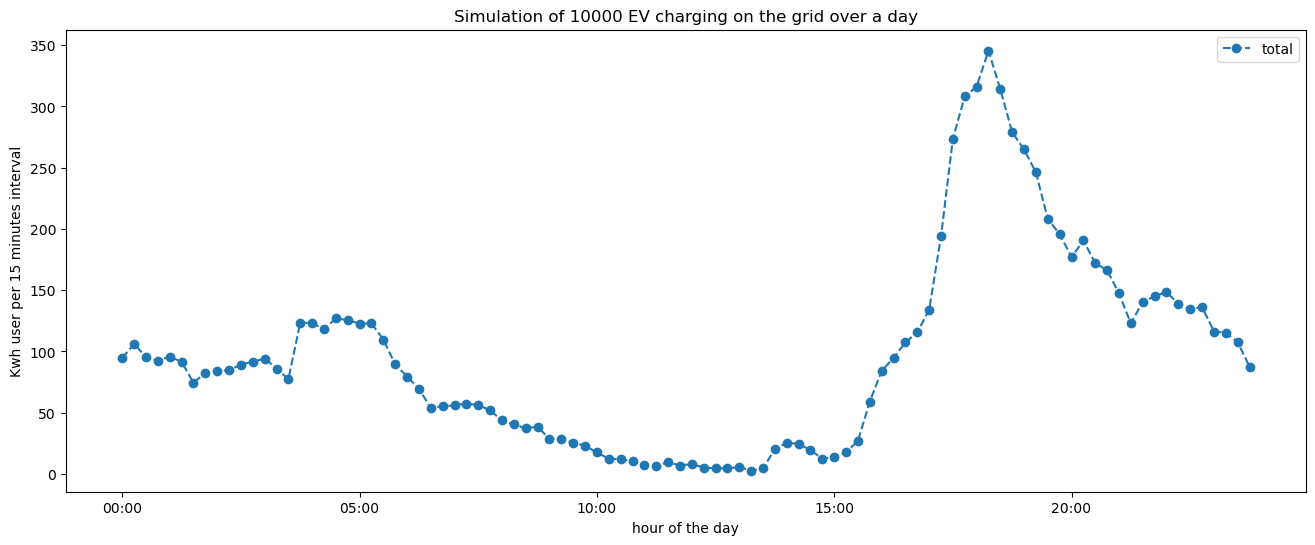

In [ ]:
# from df_summed plot all the columns 

# Plot the DataFrame
plt.figure(figsize=(16, 6))

# Plot "car_" columns
# df_summed.filter(like='car_').plot(ax=plt.gca())

# Plot "total", "up", and "down"
df_summed[['total']].plot(ax=plt.gca(), linestyle='--', marker='o')

# Set labels and title
plt.xlabel('hour of the day')
plt.ylabel('Kwh user per 15 minutes interval')
plt.title('Simulation of 10000 EV charging on the grid over a day')

# Show the plot
# plt.legend()
plt.show()



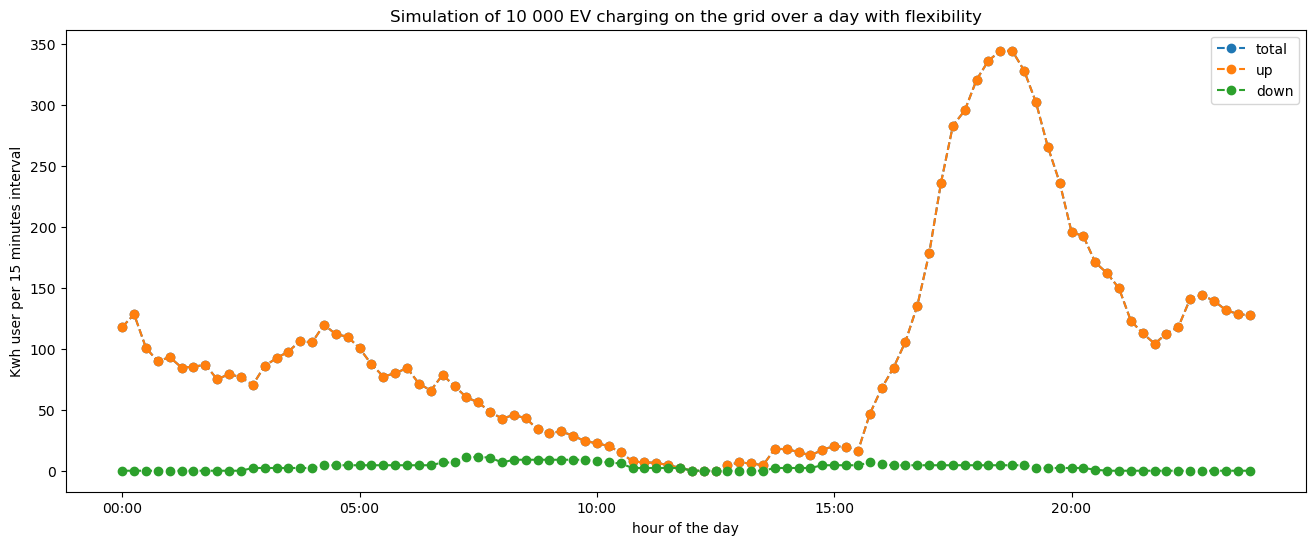

In [133]:
# from df_summed plot all the columns 

# Plot the DataFrame
plt.figure(figsize=(16, 6))

# Plot "car_" columns
# df_summed.filter(like='car_').plot(ax=plt.gca())

# Plot "total", "up", and "down"
df_summed[['total', 'up', 'down']].plot(ax=plt.gca(), linestyle='--', marker='o')

# Set labels and title
plt.xlabel('hour of the day')
plt.ylabel('Kwh user per 15 minutes interval')
plt.title('Simulation of 10 000 EV charging on the grid over a day with flexibility')

# Show the plot
plt.legend()
plt.show()


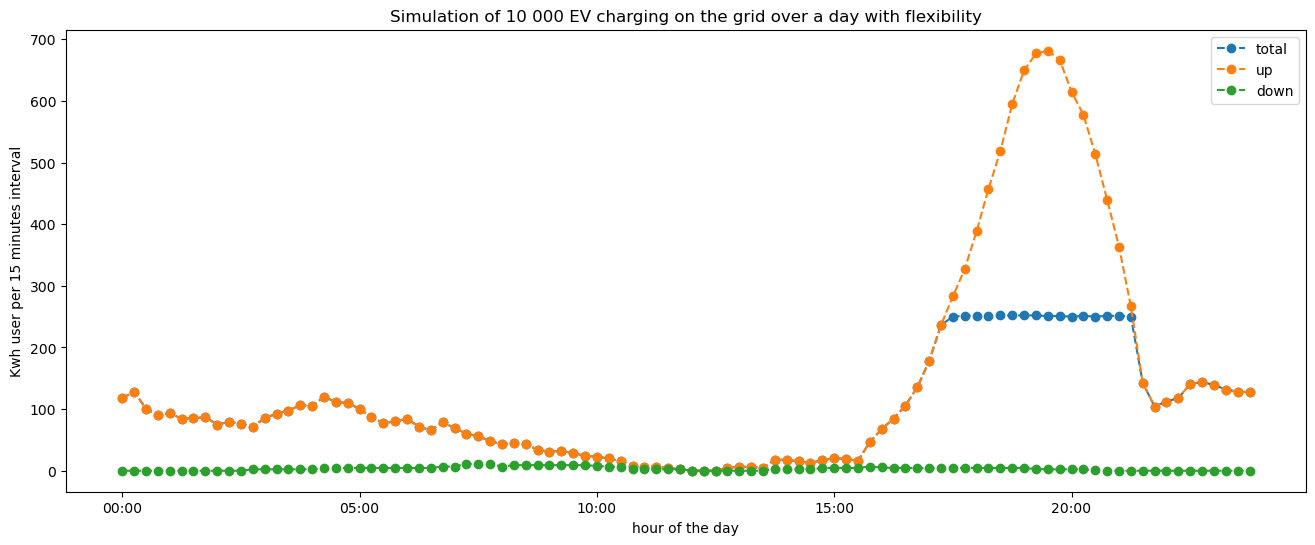

In [136]:
# from df_summed plot all the columns 

# Plot the DataFrame
plt.figure(figsize=(16, 6))

# Plot "car_" columns
# df_summed.filter(like='car_').plot(ax=plt.gca())

# Plot "total", "up", and "down"
df_summed_reg[['total', 'up', 'down']].plot(ax=plt.gca(), linestyle='--', marker='o')

# Set labels and title
plt.xlabel('hour of the day')
plt.ylabel('Kwh user per 15 minutes interval')
plt.title('Simulation of 10 000 EV charging on the grid over a day with flexibility')

# Show the plot
plt.legend()
plt.show()


In [ ]:
def get_total_power_from_model(df):
    columns_to_iterate = ['plug_in_time', 'energy_needed', 'power']

    df_final = pd.DataFrame(columns=['time', 'power'])

    # Iterate over rows with selected columns
    for index, row in df_test.iterrows():
        for column in columns_to_iterate:
            df = model_charging(datetime.strptime(row['plug_in_time'], "%H:%M"), row['energy_needed'], row['power'])
            if index == 0:
                df_final = df.copy()
            else:
                df_final["power"] = df_final["power"] + df["power"]
    return df_final

In [ ]:
df_final_normal = get_total_power_from_model(df_test)

In [ ]:
df_final

,time,power,time_as_string
0,00:00:00,1555.739191,00:00
1,00:15:00,1606.459783,00:15
2,00:30:00,1666.763168,00:30
3,00:45:00,1764.434263,00:45
4,01:00:00,1826.914263,01:00
...,...,...,...
91,22:45:00,1318.770757,22:45
92,23:00:00,1379.824757,23:00
93,23:15:00,1403.767983,23:15
94,23:30:00,1479.606383,23:30


In [ ]:
df_final_normal

,time,power
0,00:00:00,243
1,00:15:00,243
2,00:30:00,216
3,00:45:00,216
4,01:00:00,216
...,...,...
91,22:45:00,378
92,23:00:00,378
93,23:15:00,378
94,23:30:00,351


/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

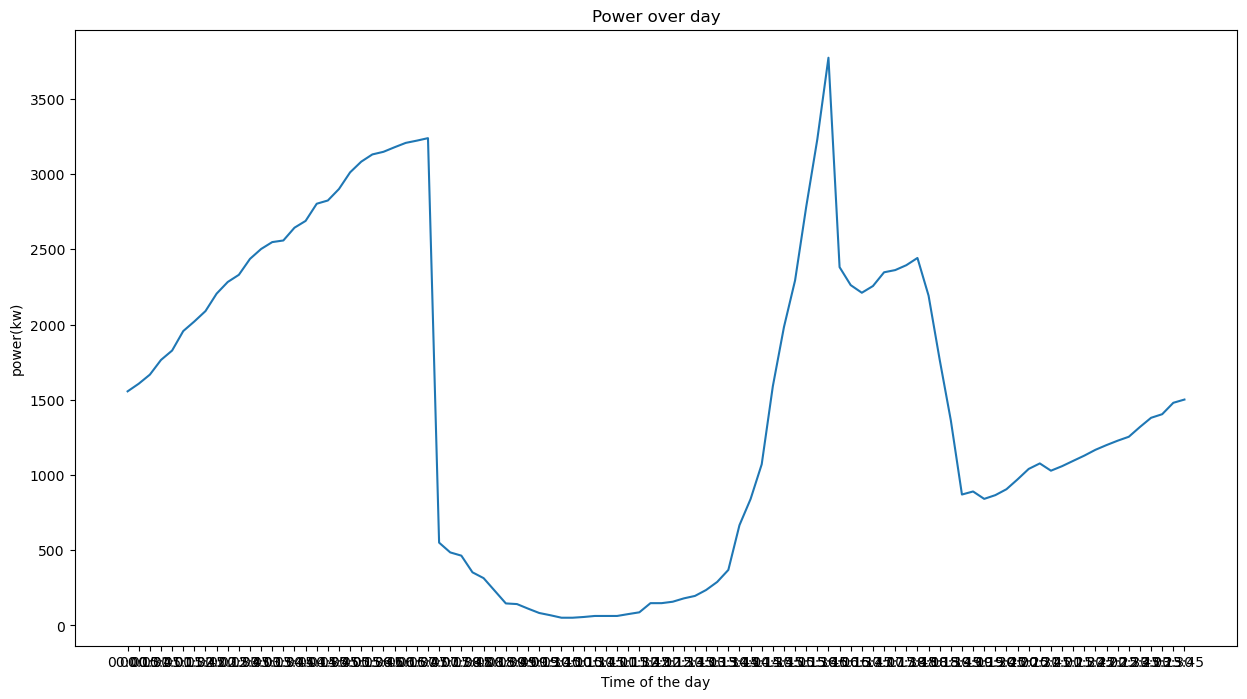

In [ ]:
# plot power over day from df_final

df_final['time_as_string'] = df_final['time'].apply(lambda x: x.strftime('%H:%M'))

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()

/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yanistournier/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. 

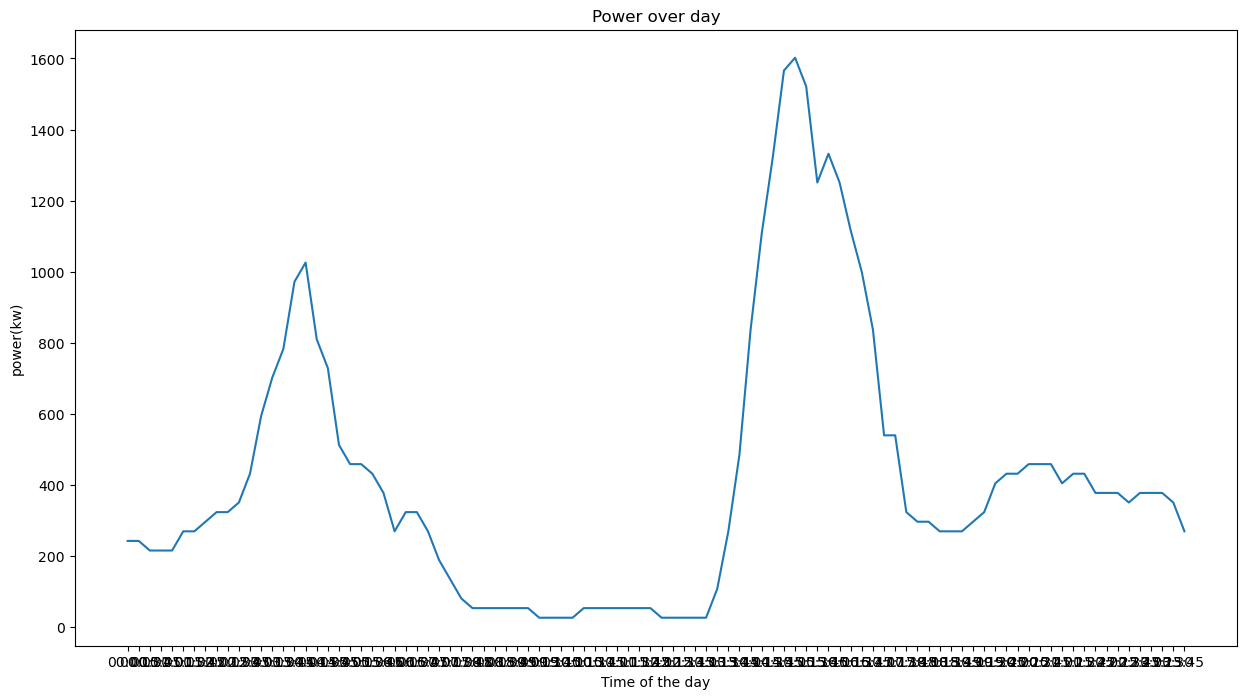

In [ ]:
df_final_normal['time_as_string'] = df_final_normal['time'].apply(lambda x: x.strftime('%H:%M'))

plt.figure(figsize=(15, 8))
sns.lineplot(data=df_final_normal, x='time_as_string', y='power')
plt.xlabel('Time of the day')
plt.ylabel('power(kw)')
plt.title('Power over day')
plt.show()